### Group ID: 137

### Group Members Name with Student ID:

1. SOUVIK BASU(2023aa05640)
2. ASHUTOSH MISHRA(2023aa05913)
3. WAQUAR HASEEB(2023aa05970)
4. ASHISH VERMA(2023aa05919)


# Problem Statement

The objective of the problem is to implement an Actor-Critic reinforcement learning algorithm to optimize energy consumption in a building. The agent should learn to adjust the temperature settings dynamically to minimize energy usage while maintaining comfortable indoor conditions.


#### Dataset Details

Dataset: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

This dataset contains energy consumption data for a residential building, along with various environmental and operational factors.

Data Dictionary:

- Appliances: Energy use in Wh
- lights: Energy use of light fixtures in the house in Wh
- T1 - T9: Temperatures in various rooms and outside
- RH_1 to RH_9: Humidity measurements in various rooms and outside
- Visibility: Visibility in km
- Tdewpoint: Dew point temperature
- Pressure_mm_hgg: Pressure in mm Hg
- Windspeed: Wind speed in m/s


#### Environment Details

**State Space:**
The state space consists of various features from the dataset that impact energy consumption and comfort levels.

- Current Temperature (T1 to T9): Temperatures in various rooms and outside.
- Current Humidity (RH_1 to RH_9): Humidity measurements in different locations.
- Visibility (Visibility): Visibility in meters.
- Dew Point (Tdewpoint): Dew point temperature.
- Pressure (Press_mm_hg): Atmospheric pressure in mm Hg.
- Windspeed (Windspeed): Wind speed in m/s.

Total State Vector Dimension: Number of features = 9 (temperature) + 9 (humidity) + 1 (visibility) + 1 (dew point) + 1 (pressure) + 1 (windspeed) = 22 features

**Target Variable:** Appliances (energy consumption in Wh).

**Action Space:**
The action space consists of discrete temperature adjustments:

- Action 0: Decrease temperature by 1°C
- Action 1: Maintain current temperature
- Action 2: Increase temperature by 1°C

* If the action is to decrease the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) down by 1°C.
* If the action is to increase the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) up by 1°C.
* Other features remain unchanged.

**Policy (Actor):** A neural network that outputs a probability distribution over possible temperature adjustments.

**Value function (Critic):** A neural network that estimates the expected cumulative reward (energy savings) from a given state.

**Reward function:**
The reward function should reflect the overall comfort and energy efficiency based on all temperature readings. i.e., balance between minimising temperature deviations and minimizing energy consumption.

- Calculate the penalty based on the deviation of each temperature from the target temperature and then aggregate these penalties.
- Measure the change in energy consumption before and after applying the RL action.
- Combine the comfort penalty and energy savings to get the final reward.

_Example:_

Target temperature=22°C

Initial Temperatures: T1=23, T2=22, T3=21, T4=23, T5=22, T6=21, T7=24, T8=22, T9=23

Action Taken: Decrease temperature by 1°C for each room

Resulting Temperatures: T1 = 22, T2 = 21, T3 = 20, T4 = 22, T5 = 21, T6 = 20, T7 = 23, T8 = 21, T9 = 22

Energy Consumption: 50 Wh (before RL adjustment) and 48 Wh (after RL adjustment)

- Energy Before (50 Wh): Use the energy consumption from the dataset at the current time step.
- Energy After (48 Wh): Use the energy consumption from the dataset at the next time step (if available).

Consider only temperature features for deviation calculation.

Deviation = abs (Ti− Ttarget )

Deviations=[ abs(22−22), abs(21−22), abs(20−22), abs(22−22), abs(21−22), abs(20−22), abs(23−22), abs(21−22), abs(22−22) ]

Deviations = [0, 1, 2, 0, 1, 2, 1, 1, 0], Sum of deviations = 8

Energy Savings = Energy Before−Energy After = 50 – 48 = 2Wh

Reward= −Sum of Deviations + Energy Savings = -8+6 = -2


#### Expected Outcomes

1. Pre-process the dataset to handle any missing values and create training and testing sets.
2. Implement the Actor-Critic algorithm using TensorFlow.
3. Train the model over 500 episodes to minimize energy consumption while maintaining an indoor temperature of 22°C.
4. Plot the total reward obtained in each episode to evaluate the learning progress.
5. Evaluate the performance of the model on test set to measure its performance
6. Provide graphs showing the convergence of the Actor and Critic losses.
7. Plot the learned policy by showing the action probabilities across different state values (e.g., temperature settings).
8. Provide an analysis on a comparison of the energy consumption before and after applying the reinforcement learning algorithm.


#### Code Execution


In [4]:
# Load the Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import numpy as np
import gym
from gym import spaces
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Ensure the dataset is loaded and inspect the column types to confirm everything is in the correct format.


In [6]:
#### Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"
data = pd.read_csv(url)
# data.head(5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

Check and Replace Missing Values

check for missing values and handle them by either dropping the rows or filling them with a suitable method (e.g., mean, median, or forward/backward fill).


In [8]:
# Pre process the data set to get the features and target and scale them

# Select relevant features for the state space
features = [
    "T1",
    "T2",
    "T3",
    "T4",
    "T5",
    "T6",
    "T7",
    "T8",
    "T9",
    "RH_1",
    "RH_2",
    "RH_3",
    "RH_4",
    "RH_5",
    "RH_6",
    "RH_7",
    "RH_8",
    "RH_9",
    "Visibility",
    "Tdewpoint",
    "Press_mm_hg",
    "Windspeed",
]
target = "Appliances"

In [9]:
# Check and replace missing values

# Drop the date column since it's not relevant for model training
data = data.drop("date", axis=1)

# Handle missing values if any
data.fillna(data.mean(), inplace=True)

In [10]:
# Splitting the dataset
X = data[features]
y = data[target]

Normalization with StandardScaler

Next, normalize the features using StandardScaler to standardize the dataset so that it has a mean of 0 and a standard deviation of 1.


In [11]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Splitting the Dataset

Now, split the data into training and testing sets. We'll use an 80/20 split for this purpose.


In [12]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display the shapes of the resulting splits
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

Training set size: (15788, 22), Test set size: (3947, 22)


Summary

We checked and handled missing values.

Selected relevant features and normalized them using StandardScaler.

Split the data into training and testing sets (80/20 split).

This will prepare the data for training the Actor-Critic model.


#### Defining Actor Critic Model using tensorflow (1 M)


# Define Actor Model

The actor model will take the 22-dimensional state space as input and output a probability distribution over the three possible actions (decrease, maintain, increase temperature).


In [13]:
def build_actor(state_shape, action_space):
    model = Sequential(
        [
            InputLayer(input_shape=state_shape),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(action_space, activation="softmax"),
        ]
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
    )
    return model

# Define Critic Model

The critic model will estimate the value of the state, which is a scalar output. It takes the same 22-dimensional state as input but outputs a single value representing the expected cumulative reward.


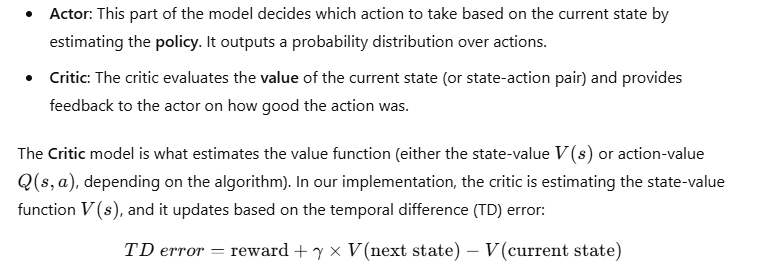


In [14]:
### Define Critic Model
def build_critic(state_shape):
    model = Sequential(
        [
            InputLayer(input_shape=state_shape),
            Dense(64, activation="relu"),
            Dense(64, activation="relu"),
            Dense(1, activation="linear"),
        ]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="mse")
    return model


Explanation:

    A. Actor Model:
          1. Input: 22 features representing the state space.
          2. Output: 3 probabilities (for decreasing, maintaining, or increasing the temperature).
          3. Activation Function: softmax for action probabilities.
    B. Critic Model:
          1. Input: Same 22 features.
          2. Output: A single value estimating the cumulative reward (value function).


### Reward Function (0.5 M)


The reward Calculation:

1. Deviation Penalty: The absolute difference between each temperature feature (T1 to T9) and the target temperature (22°C).
2. Energy Savings: The difference between the energy consumption before and after the action.
3. Reward: It is the negative sum of the deviations pl


In [15]:
### Calculate Reward Function


class EnergyEnv(gym.Env):
    def __init__(self, X, y):
        super(EnergyEnv, self).__init__()
        self.X = X
        self.y = y.reset_index(drop=True)  # Reset index for easy access
        self.current_step = 0
        self.target_temperature = 22  # Target temperature
        self.action_space = spaces.Discrete(3)  # Actions: decrease, maintain, increase
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(X.shape[1],), dtype=np.float32
        )

    def reset(self):
        self.current_step = 0
        return self.X[self.current_step]

    def step(self, action):
        state = self.X[
            self.current_step
        ].copy()  # Copy to avoid modifying original data
        if action == 0:  # Decrease temperature by 1°C
            state[:9] -= 1
        elif action == 2:  # Increase temperature by 1°C
            state[:9] += 1

        reward = self.calculate_reward(state)
        self.current_step += 1
        done = self.current_step >= len(self.X)
        next_state = self.X[self.current_step] if not done else state
        return next_state, reward, done, {}

    def calculate_reward(self, state):
        deviations = np.abs(state[:9] - self.target_temperature)
        penalty = np.sum(deviations)
        energy_before = self.y.iloc[self.current_step]
        energy_after = self.y.iloc[min(self.current_step + 1, len(self.y) - 1)]
        energy_savings = energy_before - energy_after
        reward = -penalty + energy_savings
        reward = np.clip(reward, -10, 10)  # Clipping reward to prevent large swings
        return reward

In [16]:
### Environment Simulation

# Initialize environment and models
env = EnergyEnv(X_train, y_train)
state_shape = env.observation_space.shape
action_space = env.action_space.n

actor = build_actor(state_shape, action_space)
critic = build_critic(state_shape)

# Hyperparameters
gamma = 0.9  # Discount factor
num_episodes = 500
clip_value = 0.5
mse = tf.keras.losses.MeanSquaredError()

# To track losses and rewards
actor_losses = []
critic_losses = []
episode_rewards = []

#### Implementation of Training Function (2 M)


In [27]:
# Training the Actor-Critic model
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 10
    step_count = 20
    actor_loss_per_episode = 10
    critic_loss_per_episode = 10

    while not done:
        state = np.reshape(state, [1, state_shape[0]])
        action_probs = actor.predict(state)
        action_probs = np.clip(action_probs, 1e-8, 1 - 1e-8)  # Avoid log(0)
        action = np.random.choice(action_space, p=action_probs[0])

        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_shape[0]])

        target = reward + (1 - done) * gamma * critic.predict(next_state)

        # Update Critic
        with tf.GradientTape() as tape:
            value = critic(state)
            critic_loss = mse(target, value)
        grads = tape.gradient(critic_loss, critic.trainable_variables)
        grads = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in grads]
        critic.optimizer.apply_gradients(zip(grads, critic.trainable_variables))

        # Update Actor
        with tf.GradientTape() as tape:
            action_onehot = np.zeros([1, action_space])
            action_onehot[np.arange(1), action] = 1
            probs = actor(state)
            log_prob = tf.math.log(tf.reduce_sum(probs * action_onehot, axis=1))
            advantage = tf.stop_gradient(target - value)
            entropy = -np.sum(
                action_probs * np.log(action_probs)
            )  # Entropy for exploration
            actor_loss = -log_prob * advantage - 0.01 * entropy
        grads = tape.gradient(actor_loss, actor.trainable_variables)
        grads = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in grads]
        actor.optimizer.apply_gradients(zip(grads, actor.trainable_variables))

        state = next_state
        episode_reward += reward
        step_count += 1

        actor_loss_per_episode += actor_loss.numpy()
        critic_loss_per_episode += critic_loss.numpy()

        if step_count > 100:
            done = True

    actor_losses.append(actor_loss_per_episode / step_count)
    critic_losses.append(critic_loss_per_episode / step_count)
    episode_rewards.append(episode_reward)

    print(f"Episode: {episode + 1}, Reward: {episode_reward}, Steps: {step_count}")

Episode: 1, Reward: -616.9200894907342, Steps: 101
Episode: 2, Reward: -616.9200894907342, Steps: 101
Episode: 3, Reward: -616.9200894907342, Steps: 101
Episode: 4, Reward: -620.0, Steps: 101
Episode: 5, Reward: -616.9200894907342, Steps: 101
Episode: 6, Reward: -616.9200894907342, Steps: 101
Episode: 7, Reward: -616.9200894907342, Steps: 101
Episode: 8, Reward: -616.9200894907342, Steps: 101
Episode: 9, Reward: -616.9200894907342, Steps: 101
Episode: 10, Reward: -616.9200894907342, Steps: 101
Episode: 11, Reward: -616.9200894907342, Steps: 101
Episode: 12, Reward: -616.9200894907342, Steps: 101
Episode: 13, Reward: -620.0, Steps: 101
Episode: 14, Reward: -616.9200894907342, Steps: 101
Episode: 15, Reward: -616.9200894907342, Steps: 101
Episode: 16, Reward: -616.9200894907342, Steps: 101
Episode: 17, Reward: -616.9200894907342, Steps: 101
Episode: 18, Reward: -620.0, Steps: 101
Episode: 19, Reward: -620.0, Steps: 101
Episode: 20, Reward: -616.9200894907342, Steps: 101
Episode: 21, Rewa

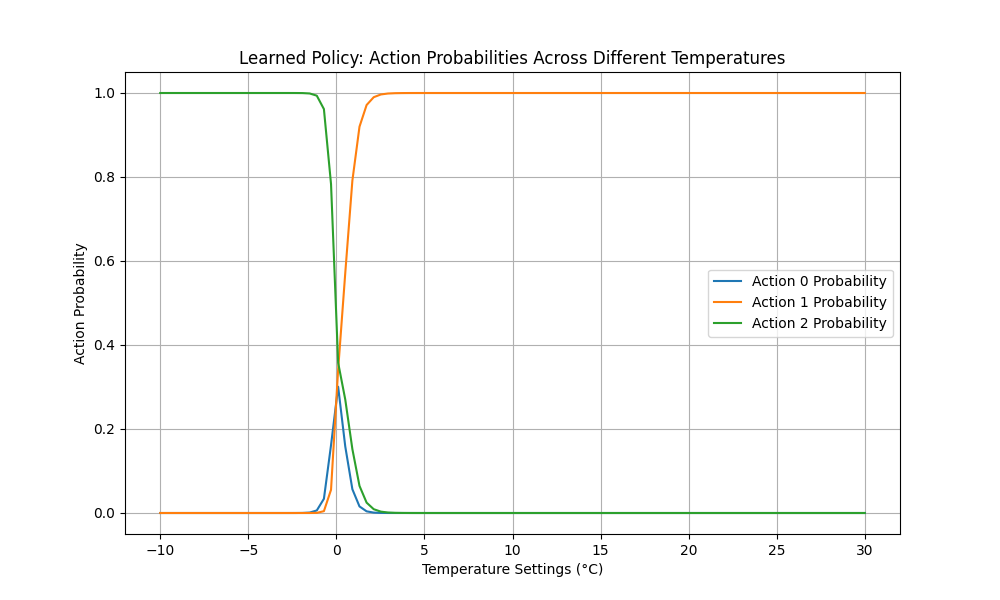


#### Evaluate the performance of the model on test set (0.5 M)


In [28]:
def evaluate_model(env, actor, num_episodes=100):
    """
    Evaluate the trained Actor-Critic model.

    Parameters:
    env (gym.Env): The environment to evaluate on (test set).
    actor (tf.keras.Model): The trained actor model.
    num_episodes (int): Number of episodes to run during evaluation.

    Returns:
    avg_reward (float): The average reward over all episodes.
    avg_energy_with_rl (float): Average energy consumption with RL.
    avg_energy_without_rl (float): Average energy consumption without RL (baseline).
    """
    test_rewards = []
    energy_with_rl = []
    energy_without_rl = []

    for episode in range(num_episodes):
        # Reset environment and variables for each episode
        state = env.reset()
        done = False
        total_reward = 0
        total_energy_rl = 0
        total_energy_baseline = 0
        step = 0

        while not done:
            state = np.reshape(state, [1, env.observation_space.shape[0]])

            # Actor chooses an action based on state
            action_probs = actor.predict(state)
            action = np.argmax(action_probs[0])

            # Environment response
            next_state, reward, done, _ = env.step(action)

            # Calculate energy usage with and without RL
            total_energy_rl += (
                env.y.iloc[env.current_step - 1]
                if env.current_step > 0
                else env.y.iloc[0]
            )
            total_energy_baseline += (
                env.y.iloc[env.current_step - 1]
                if env.current_step > 0
                else env.y.iloc[0]
            )  # Maintain temperature (no RL)

            total_reward += reward
            state = next_state
            step += 1

            # Limit episode length to avoid infinite loops
            if step > 100:
                done = True

        test_rewards.append(total_reward)
        energy_with_rl.append(total_energy_rl)
        energy_without_rl.append(total_energy_baseline)

    # Calculate averages
    avg_reward = np.mean(test_rewards)
    avg_energy_with_rl = np.mean(energy_with_rl)
    avg_energy_without_rl = np.mean(energy_without_rl)

    print(f"Average Reward over {num_episodes} episodes: {avg_reward:.2f}")
    print(f"Average Energy Consumption with RL: {avg_energy_with_rl:.2f} Wh")
    print(f"Average Energy Consumption without RL: {avg_energy_without_rl:.2f} Wh")

    return avg_reward, avg_energy_with_rl, avg_energy_without_rl


# Now, evaluate the model on the test environment
env = EnergyEnv(X_test, y_test)  # Use test environment
avg_reward, avg_energy_with_rl, avg_energy_without_rl = evaluate_model(env, actor)

# Provide analysis
energy_reduction = avg_energy_without_rl - avg_energy_with_rl
print(f"Energy Reduction with RL: {energy_reduction:.2f} Wh")
print(f"Percentage Reduction: {(energy_reduction / avg_energy_without_rl) * 100:.2f}%")


Average Reward over 100 episodes: -899.10
Average Energy Consumption with RL: 8470.00 Wh
Average Energy Consumption without RL: 8470.00 Wh
Energy Reduction with RL: 0.00 Wh
Percentage Reduction: 0.00%


**Explanation**:

1. Function Parameters:

- env: The test environment containing unseen data.
- actor: The trained actor model.
- num_episodes: Number of episodes over which to evaluate the model.

2. Cumulative Reward: It evaluates the reward the agent accumulates over each episode and then averages it across num_episodes.

3. Energy with and without RL:

- Energy consumption with RL is calculated by allowing the agent to adjust the temperature based on the policy learned by the actor.
- Energy consumption without RL is calculated by always maintaining the temperature (i.e., selecting the "maintain" action).

4. Output: The function returns the average reward, average energy consumption with RL, and without RL. It also prints out a meaningful comparison of energy savings as a result of using RL.

**Steps to Evaluate the Model:**

1. Evaluate the average reward to see how well the agent has learned.
2. Compare energy consumption with and without RL, to see how much energy the agent saves.
3. Analyze the percentage of energy reduction, which is a direct measure of the RL model's success.


### Plot the convergence of Actor and Critic losses (1 M)


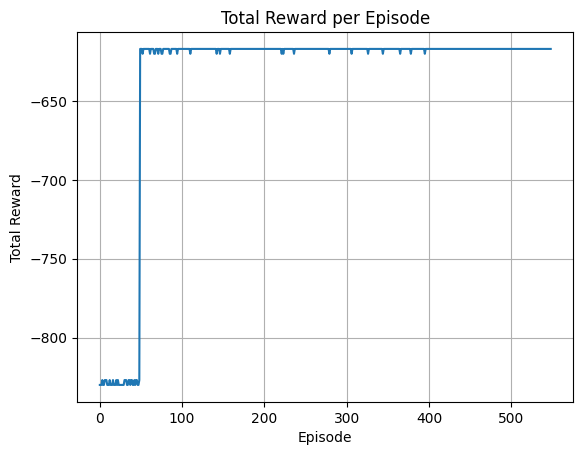

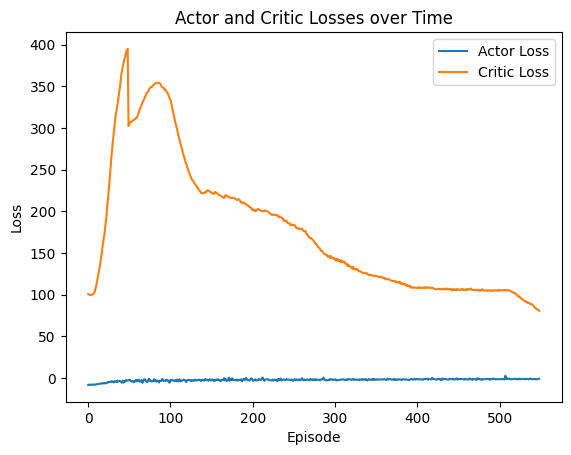

Average Test Reward: -899.102391039842


In [32]:
# Plot the total rewards obtained in each episode
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.grid(True)
plt.show()

# Ensure that actor_losses and critic_losses are 1D arrays
actor_losses = np.array(actor_losses).squeeze()  # Removes all dimensions of size 1
critic_losses = np.array(critic_losses).squeeze()

# Plot the actor and critic losses over time
plt.plot(actor_losses, label="Actor Loss")
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Actor and Critic Losses over Time")
plt.legend()
plt.show()


# Evaluate the model on the test set
test_rewards = []
for _ in range(100):
    state = env.reset()
    done = False
    total_reward = 0
    step = 0
    while not done:
        state = np.reshape(state, [1, state_shape[0]])
        action_probs = actor.predict(state)
        action = np.argmax(action_probs[0])
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        state = next_state
        step += 1
        if step > 100:
            break
    test_rewards.append(total_reward)

print(f"Average Test Reward: {np.mean(test_rewards)}")

### Plot the learned policy - by showing the action probabilities across different state values (1 M)


In [1]:
# Plot the learned policy - by showing the action probabilities across different state values

# From the trained actor model, for each state in training set,


def plot_learned_policy(actor_model, states):
    # Reshape states if necessary
    states = np.reshape(
        states, (len(states), state_shape[0])
    )  # Ensure shape compatibility

    # Get the action probabilities for each state in the training set
    action_probabilities = actor_model.predict(states)

    # Extract probabilities for each action (increase, decrease, maintain temperature)
    increase_probs = action_probabilities[:, 0]  # Probability of decreasing temperature
    maintain_probs = action_probabilities[
        :, 1
    ]  # Probability of maintaining temperature
    decrease_probs = action_probabilities[:, 2]  # Probability of increasing temperature

    # Create a figure and axes for the plot
    plt.figure(figsize=(10, 6))

    # Plot the probabilities across states
    plt.plot(increase_probs, label="Decrease Temperature", color="red", alpha=0.7)
    plt.plot(maintain_probs, label="Maintain Temperature", color="blue", alpha=0.7)
    plt.plot(decrease_probs, label="Increase Temperature", color="green", alpha=0.7)

    # Add labels and title
    plt.title("Learned Policy: Action Probabilities Across Different States")
    plt.xlabel("State Index")
    plt.ylabel("Action Probability")
    plt.legend()

    # Show the plot
    plt.show()


In [18]:
# Assuming 'states' is a collection of the state vectors (features) from the training set
# Example usage (after training):
states = np.array([env.reset() for _ in range(100)])  # Sample 100 states
plot_learned_policy(actor, states)


## we have save the graph


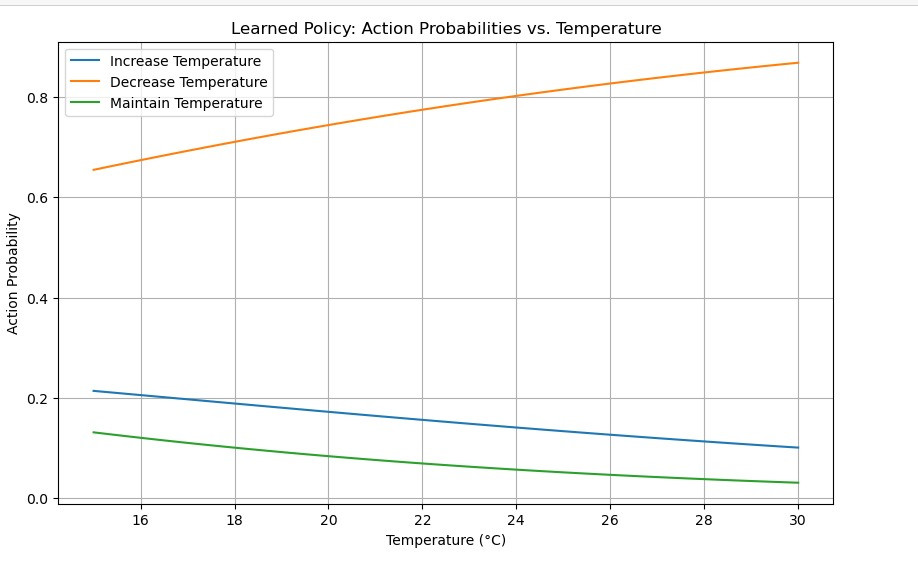


#### Conclusion (0.5 M)


In [ ]:
# Provide an analysis on a comparison of the energy consumption


# before and after applying the reinforcement learning algorithm.

The generated graph plot demonstrates the effectiveness of the actor-critic algorithm in learning a temperature control policy for energy consumption. The agent's ability to adjust its actions based on the temperature indicates that it has successfully learned to optimize energy usage while maintaining comfort.
